In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from umap import UMAP
import numba
from collections import Counter
from gudhi.clustering.tomato import Tomato

In [2]:
activity = np.load("activations/ILSVRC2015/inception4a.npy")
# activity = pd.DataFrame(data=activity)

<AxesSubplot:>

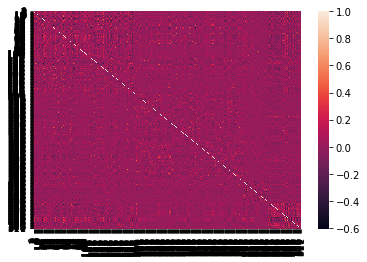

In [8]:
corr = pd.DataFrame(data=activity).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [9]:
so = corr.unstack().sort_values(kind="quicksort")

top = 20
print(so[-top - activity.shape[1] : -activity.shape[1]])
print(so[:top])

262  241    0.565414
241  262    0.565414
291  180    0.569673
180  291    0.569673
485  482    0.572965
482  485    0.572965
357  298    0.585621
298  357    0.585621
430  427    0.592032
427  430    0.592032
303  197    0.595535
197  303    0.595535
     152    0.622691
152  197    0.622691
447  413    0.625472
413  447    0.625472
485  492    0.628837
492  485    0.628837
425  443    0.683659
443  425    0.683659
dtype: float64
9    157   -0.603328
157  9     -0.603328
427  425   -0.597858
425  427   -0.597858
57   17    -0.562226
17   57    -0.562226
149  21    -0.553534
21   149   -0.553534
157  14    -0.540135
14   157   -0.540135
134  76    -0.532540
76   134   -0.532540
134  189   -0.523915
189  134   -0.523915
131  44    -0.493220
44   131   -0.493220
263  256   -0.484942
256  263   -0.484942
485  500   -0.482312
500  485   -0.482312
dtype: float64


In [27]:
from scipy.stats import pearsonr


def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [28]:
pval = calculate_pvalues(activity)

so = pval.unstack().sort_values(kind="quicksort")

top = 10
print(so[-top - activity.shape[1] : -activity.shape[1]])
print(so[:top])

337  90     0.9779
90   337    0.9779
199  292    0.9779
292  199    0.9779
223  418    0.9779
422  454    0.9779
418  223    0.9779
451  231    0.9779
136  332     0.978
332  136     0.978
dtype: object
0    0      0.0
311  305    0.0
     306    0.0
     307    0.0
     308    0.0
     310    0.0
     311    0.0
     312    0.0
     314    0.0
     316    0.0
dtype: object


In [44]:
so.value_counts()

0.0000    188194
0.0001      4486
0.0002      2178
0.0003      1510
0.0004      1054
           ...  
0.3225         2
0.7238         2
0.3224         2
0.7241         2
0.9999         2
Length: 8185, dtype: int64

In [50]:
# Fixing umap bug. https://gitmetadata.com/repo/lmcinnes/pynndescent/issues/163


@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result


import pynndescent

pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

In [4]:
layout = UMAP(
    n_components=2, verbose=True, n_neighbors=5, min_dist=0.01, metric="correlation"
).fit_transform(activity.T)

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.01, n_neighbors=5, verbose=True)
Fri Mar  4 10:14:24 2022 Construct fuzzy simplicial set
Fri Mar  4 10:14:37 2022 Finding Nearest Neighbors
Fri Mar  4 10:14:38 2022 Finished Nearest Neighbor Search
Fri Mar  4 10:14:39 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar  4 10:14:40 2022 Finished embedding


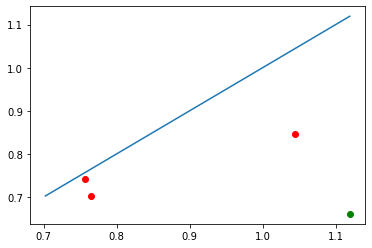

In [5]:
t = Tomato(density_type="DTM", k=100)  # logDTM
clusters = t.fit_predict(layout)
t.plot_diagram()

In [6]:
print(t.n_clusters_)
# t.n_clusters_ = 4
print(Counter(t.labels_).most_common(10))

4
[(1, 156), (2, 149), (0, 133), (3, 74)]


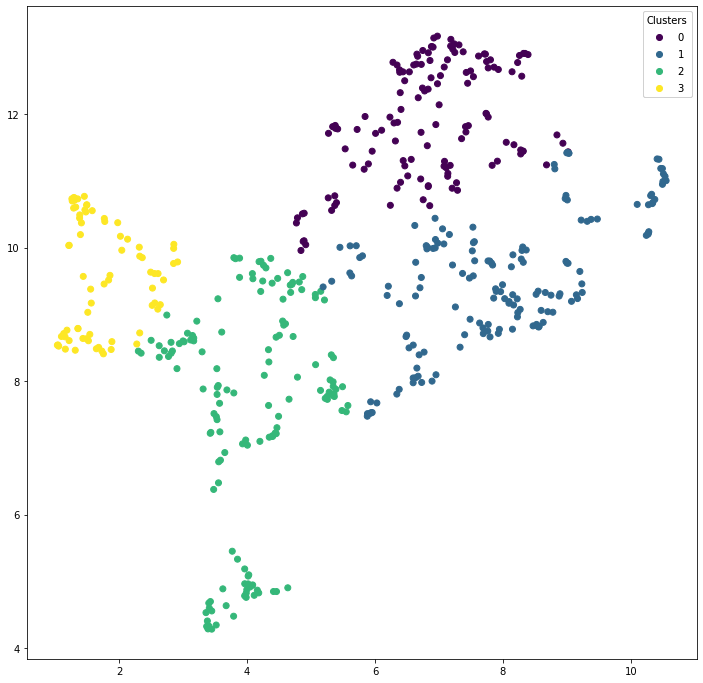

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout[:, 0], y=layout[:, 1], c=t.labels_)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()